In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scienceplots
import nbimporter
from scipy.special import erf

from Models_clean import model_fit
# from npdfplot import *
plt.style.use('science')

col1='royalblue'
col2='forestgreen'
col3='mediumorchid'

plt.rc('axes', prop_cycle=plt.cycler(color=['blue', 'gray', 'orange', 'brown', 'deepskyblue', 'green']))

In [2]:
params_list_tex=[r'$\log(m_{\chi})$', r'$f_{\rm rel}$', r'$f_{\beta}$', r'$\log\mathcal{N}_{\rm UPS}$', r'$\theta_{\rm UPS}$',
                 r'$\log\mathcal{N}_{\rm CMB}$', r'$\log x_{\rm FIR}$', r'$\log x_{\rm NIR}$', r'$p$', r'$f_{\rm Ps}$']
params_list= ['log_m_chi', 'f_rel', 'f_beta', 'log_norm_UPS', 'angle_UPS',
              'log_norm_CMB', 'log_x_FIR', 'log_x_NIR', 'p', 'f_Ps']

## Notebook to produce posterior plots

 ### Code to create plots

In [138]:
class constr_plot:
    def __init__(self, N, spi_data, model, env_gas, p_f_sync, **args):
        self.N=N
        self.nchains=args.get('nchains', 104)
        self.model=model.split('_')[-1]
        self.spi_data=spi_data
        self.roi=spi_data.split('_')[-1].strip('data')
        if self.roi=='':
            self.roi='95'
        self.env_gas=env_gas
        self.p_f_sync=p_f_sync
        self.mcmc_file=f'../data/mcmc_output/samples_{env_gas}_m{p_f_sync}_{model}_{N/1000:.1f}k_{spi_data}.npz'
        self.mcmc_data=np.load(self.mcmc_file)
        # self.pos_file=f'../data/criptic_output/simdata_{env_gas}_m{p_f_sync}_pos_onedata.npz'
        # self.pos_data=np.load(self.pos_file)
        
        # Give the list of parameters
        # Either import from the mcmc data
        # self.params=list(self.mcmc_data['list_params'])
        # Or specify the parameter names yourself
        self.params=params_list.copy()
        self.params_tex=params_list_tex.copy()
        
        self.loglkl=-self.mcmc_data['log_probs']
        self.samples=self.mcmc_data['samples']
        self.__initial_dof = len(self.params)
        self.minisample_size=args.get('minisample_size', N//20)
        self.process_initial()

    def process_initial(self):
        self._dict_={}
        for i, p in enumerate(self.params):
            self._dict_[p]=self.samples[:, i]

        self.whether_prior_lims=[0 for i in self.params]
        self.prior_lims={}

        self.bestfit=np.where(self.loglkl==np.min(self.loglkl))[0][0]
        self.minisample=np.random.choice(self.N, self.minisample_size, replace=False)

    def has_prior_lims(self, par):
        idx=self.params.index(par)
        return not (self.whether_prior_lims[idx]==0)

    def set_prior_lims(self, par, min_val=None, max_val=None):
        idx=self.params.index(par)
        self.whether_prior_lims[idx]=1
        self.prior_lims[par]=(min_val, max_val)

    def covplot(self, par1, par2, max_loglkl=1000., kde=False, ax=None, addbestfit=False, minisample=False, style='filled', **kwargs):
        if not ax:
            ax=plt.axes()
        idx1=self.params.index(par1)
        idx2=self.params.index(par2)

        if minisample:
            loglkl=self.loglkl[self.minisample]
            x1=self.samples[self.minisample, idx1]
            x2=self.samples[self.minisample, idx2]
        else:
            loglkl=self.loglkl
            x1=self.samples[:, idx1]
            x2=self.samples[:, idx2]
        sel=(loglkl<max_loglkl)
        x1=x1[sel]
        x2=x2[sel]
        
        if self.has_prior_lims(par1):
            clip1=(self.prior_lims[par1][0] if not self.prior_lims[par1][0]==None else np.min(x1), 
                  self.prior_lims[par1][1] if not self.prior_lims[par1][1]==None else np.max(x1))
        else:
            clip1=(np.min(x1), np.max(x1))
        if self.has_prior_lims(par2):
            clip2=(self.prior_lims[par2][0] if not self.prior_lims[par2][0]==None else np.min(x2), 
                  self.prior_lims[par2][1] if not self.prior_lims[par2][1]==None else np.max(x2))
        else:
            clip2=(np.min(x2), np.max(x2))
        # plt.scatter(x1, x2, s=2)
        if kde and style=='filled':
            sns.kdeplot(x=x1, y=x2, gridsize=50, levels=[0.0455, 0.3173, 1], fill=True, bw_adjust=2., ax=ax, clip=(clip1, clip2), **kwargs)
        elif kde and style=='contours':
            sns.kdeplot(x=x1, y=x2, gridsize=50, levels=[0.0455], fill=False, bw_adjust=2., linewidths=0.5, 
                        ax=ax, clip=(clip1, clip2), **kwargs)
            sns.kdeplot(x=x1, y=x2, gridsize=50, levels=[0.3173], fill=False, bw_adjust=2., linewidths=1.0, 
                        ax=ax, clip=(clip1, clip2), **kwargs)
        elif kde and style=='contours_alt':
            sns.kdeplot(x=x1, y=x2, gridsize=50, levels=[0.0455], fill=False, bw_adjust=2., linewidths=1.0, 
                        ax=ax, clip=(clip1, clip2), **kwargs)
            sns.kdeplot(x=x1, y=x2, gridsize=50, levels=[0.3173, 1], fill=True, bw_adjust=2., 
                        ax=ax, clip=(clip1, clip2), **kwargs)
        else:
            ax.hist2d(x1, x2, bins=40)
        if self.has_prior_lims(par1):
            ax.set_xlim(self.prior_lims[par1][0], self.prior_lims[par1][1])
        if self.has_prior_lims(par2):
            ax.set_ylim(self.prior_lims[par2][0], self.prior_lims[par2][1])
        bestfit=np.where(loglkl==np.min(loglkl))[0][0]
        if addbestfit:
            ax.scatter(self._dict_[par1][self.bestfit], self._dict_[par2][self.bestfit], color='k', marker='*')
        ax.set_xlabel(self.params_tex[idx1])
        ax.set_ylabel(self.params_tex[idx2])

    def histplot(self, par, max_loglkl=1000., kde=False, ax=None, addbestfit=False, minisample=False, label=None,
                 style='filled', **kwargs):
        if not ax:
            ax=plt.axes()
        idx=self.params.index(par)

        if minisample:
            loglkl=self.loglkl[self.minisample]
            x=self.samples[self.minisample, idx]
        else:
            loglkl=self.loglkl
            x=self.samples[:, idx]
            
        sel=(loglkl<max_loglkl)
        x=x[sel]
        # plt.scatter(x1, x2, s=2)
        if self.has_prior_lims(par):
            clip=(self.prior_lims[par][0] if not self.prior_lims[par][0]==None else np.min(x), 
                  self.prior_lims[par][1] if not self.prior_lims[par][1]==None else np.max(x))
        else:
            clip=(np.min(x), np.max(x))
        if kde and style=='filled':
            q=sns.kdeplot(x, gridsize=50, fill=True, bw_adjust=2., ax=ax, clip=clip, label=label, **kwargs)
        elif kde and style=='contours':
            q=sns.kdeplot(x, gridsize=50, fill=False, bw_adjust=2., ax=ax, clip=clip, label=label, **kwargs)
        else:
            q=ax.hist(x, histtype='step', fill=True, alpha=0.5, label=label, **kwargs)
        # bestfit=np.where(loglkl==np.min(loglkl))[0][0]
        if self.has_prior_lims(par):
            ax.set_xlim(self.prior_lims[par][0], self.prior_lims[par][1])
        if addbestfit:
            ax.axvline(self._dict_[par][self.bestfit], ymin=0, ymax=2, color='k')
        plt.xlabel(self.params_tex[idx])
        return q

    def print_stats(self, par, max_loglkl=1000, minisample=False):
        idx=self.params.index(par)
        
        if minisample:
            loglkl=self.loglkl[self.minisample]
            x=self.samples[self.minisample, idx]
        else:
            loglkl=self.loglkl
            x=self.samples[:, idx]
            
        sel=(loglkl<max_loglkl)
        x=x[sel]
        print('\n')
        print(rf'Parameter: {self.params_tex[idx]}')

        mean=np.mean(x)
        median=np.median(x)
        sig=np.std(x)
        print(f'Mean: {mean:.3e}')

        if self.has_prior_lims(par):
            print(f'Prior limits: {self.prior_lims[par][0]} <= {self.params_tex[idx]} <= {self.prior_lims[par][1]}')

        print(f'Upper limit: {np.percentile(x, 95):.3e} (95%), {np.percentile(x, 99):.3e} (99%)')
        print(f'Lower limit: {np.percentile(x, 5):.3e} (95%), {np.percentile(x, 1):.3e} (99%)')

        print(f'1-sigma interval: {median:.3e} (+{np.percentile(x, 84.13)-median:.3e} / -{-np.percentile(x, 15.87)+median:.3e})')
        print(f'2-sigma interval: {median:.3e} (+{np.percentile(x, 97.72)-median:.3e} / -{-np.percentile(x, 2.28)+median:.3e})')

        # bestfit=np.where(loglkl==np.min(loglkl))[0][0]
        # print(bestfit)
        print(f'Best-fit: {self._dict_[par][self.bestfit]:.3e}')

    def print_stats_alt(self, par, minisample=False, max_loglkl=1000.):
        idx=self.params.index(par)
        
        if minisample:
            loglkl=self.loglkl[self.minisample]
            x=self.samples[self.minisample, idx]
        else:
            loglkl=self.loglkl
            x=self.samples[:, idx]
            
        sel=(loglkl<max_loglkl)
        x=x[sel]

        median=np.median(x)
        sig_1_p=np.percentile(x, 84.13)-median
        sig_1_m=-np.percentile(x, 15.87)+median
        sig_2_p=np.percentile(x, 97.72)-median
        sig_2_m=-np.percentile(x, 2.28)+median

        print(f'median={median:.3f}, sig_1_p={sig_1_p:.3f}, sig_1_m={sig_1_m:.3f}, sig_2_p={sig_2_p:.3f}, sig_2_m={sig_2_m:.3f}')
        
    def print_stats_alt_e(self, par, minisample=False, max_loglkl=1000.):
        idx=self.params.index(par)
        
        if minisample:
            loglkl=self.loglkl[self.minisample]
            x=self.samples[self.minisample, idx]
        else:
            loglkl=self.loglkl
            x=self.samples[:, idx]
            
        sel=(loglkl<max_loglkl)
        x=x[sel]

        median=np.median(x)
        sig_1_p=np.percentile(x, 84.13)-median
        sig_1_m=-np.percentile(x, 15.87)+median
        sig_2_p=np.percentile(x, 97.72)-median
        sig_2_m=-np.percentile(x, 2.28)+median

        print(f'median={median:.3e}, sig_1_p={sig_1_p:.3e}, sig_1_m={sig_1_m:.3e}, sig_2_p={sig_2_p:.3e}, sig_2_m={sig_2_m:.3e}')
        

    def add_derived_param(self, param_name, param_name_tex, func, pars_list):
        # Suppose you want to define f_Al26 as 1-(f_rel+f_beta)
        # Then give pars_list as ['$f_{rel}$', '$f_{\\beta}$']
        # And func as lambda x,y: 1-(x+y)
        if param_name in self.params:
            return
        par_arrays=[]
        for par in pars_list:
            par_arrays.append(self._dict_[par])
        sample_new=func(*par_arrays)
        self._dict_[param_name]=sample_new
        self.params.append(param_name)
        self.params_tex.append(param_name_tex)
        self.whether_prior_lims.append(0)
        self.samples=np.hstack([self.samples, sample_new.reshape(-1, 1)])
        return

    def init_cornerplot(self, n=1):
        return plt.subplots(n,n)

    def cornerplot(self, paramlist, max_loglkl=1000., kde_diag=False, kde_cov=False, 
                   addbestfit=False, minisample=False, fig = None, axs=None, label=None, 
                   diag_style='filled', cov_style='filled', **kwargs):
        n=len(paramlist)        
        color=kwargs.get('color', f'C{n}')
        if fig==None:
            fig, axs=plt.subplots(n,n)
        bf=self.bestfit
        for i in range(n):
            for j in range(n):
                ax=axs[i, j]
                if i<j:
                    ax.set_visible(False)
                elif i==j:
                    q=self.histplot(paramlist[i], max_loglkl=max_loglkl, kde=kde_diag, ax=ax, color=color,
                                  addbestfit=addbestfit, minisample=minisample, label=(label if i==0 else ''), style=diag_style)
                    
                    ax.yaxis.set_ticks([])
                else:
                    alpha=kwargs.get('alpha', 1.)
                    self.covplot(paramlist[j], paramlist[i], max_loglkl=max_loglkl, kde=kde_cov, ax=ax, color=color,
                                 addbestfit=addbestfit, minisample=minisample, alpha=alpha, style=cov_style)
                
                if i<n-1:
                    ax.set_xticklabels([])
                    ax.set_xlabel('')
                else:
                    idx = self.params.index(paramlist[j])
                    ax.set_xlabel(self.params_tex[idx])
                if i==0:
                    ax.set_ylabel('')
                elif j==0:
                    idx=self.params.index(paramlist[i])
                    ax.set_ylabel(self.params_tex[idx])
                if j>0:
                    ax.set_yticklabels([])
                    ax.set_ylabel('');
        fig.set_size_inches([2*n, 2*n])
                    
    def hist_loglkl(self, **kwargs):
        plt.hist(self.loglkl, bins=100, alpha=0.5, density=True, label='Full sample', **kwargs)
        plt.hist(self.loglkl[self.minisample], bins=100, histtype='step', density=True, color='k', label='Mini sample')
        plt.gcf().set_size_inches([8,2])
        plt.legend()
        plt.xlabel(r'$-\log\mathcal{L}$')

    def table(self, minisample=False, max_loglkl=1000.):
        table=[]
        header = 'Parameter & 1$\sigma$ interval & 2$\sigma$ interval & Lower limit (95\%) Upper limit (95\%)'
        table.append(header)
        for idx, par in enumerate(self.params_tex):
            if minisample:
                loglkl=self.loglkl[self.minisample]
                x=self.samples[self.minisample, idx]
            else:
                loglkl=self.loglkl
                x=self.samples[:, idx]
            sel=(loglkl<max_loglkl)
            x=x[sel]
            median=np.median(x)
            row=par
            onesigma_interval=fr' & ${median:.3f}^{{+{np.percentile(x, 84.13)-median:.3f}}}_{{-{-np.percentile(x, 15.87)+median:.3f}}}$'
            twosigma_interval=fr' & ${median:.3f}^{{+{np.percentile(x, 97.72)-median:.3f}}}_{{-{-np.percentile(x, 2.28)+median:.3f}}}$'
            lower_95=fr' & $>$ {np.percentile(x, 5):.3f}'
            upper_95=fr' & $<$ {np.percentile(x, 95):.3f}'
            row += onesigma_interval + twosigma_interval + lower_95 + upper_95
            table.append(row)
        for row in table:
            print(row, r'\\',  end='\n')

    def table_alt(self, minisample=False, max_loglkl=1000., cols=['1sig', '2sig', 'up95', 'lo95']):
        table=[]
        header = 'Parameter'
        for idx, par in enumerate(self.params_tex):
            if minisample:
                loglkl=self.loglkl[self.minisample]
                x=self.samples[self.minisample, idx]
            else:
                loglkl=self.loglkl
                x=self.samples[:, idx]
            sel=(loglkl<max_loglkl)
            x=x[sel]
            
            median=np.median(x)
            row=par
            for col in cols:
                if col.endswith('sig'):
                    sigma=float(col.strip('sig'))
                    if idx==0:
                        header += fr' & {sigma:.0f}$\sigma$ interval'
                    interval=self.sigma_bound(x, sigma=sigma, kind='both')
                    row+=fr' & ${median:.3f}^{{+{interval[1]-median:.3f}}}_{{-{median-interval[0]:.3f}}}$'
                elif col.startswith('lo'):
                    pct=float(col.strip('lo'))
                    if idx==0:
                        header += fr' & Lower limit ({pct:.0f}\%)'
                    lolim=self.pct_bound(x, pct=pct, kind='lo')
                    row += fr' & $>$ {lolim:.3f}'
                elif col.startswith('up'):
                    pct=float(col.strip('up'))
                    if idx==0:
                        header += fr' & Upper limit ({pct:.0f}\%)'
                    uplim=self.pct_bound(x, pct=pct, kind='up')
                    row += fr' & $<$ {uplim:.3f}'
            table.append(row)
        table=[header] + table
        for row in table:
            print(row, r'\\ \hline',  end='\n')

    def table_alt2_singlecol(self, minisample=False, max_loglkl=1000., lims=[], end_row=False, header_col=False):
        table=[]
        for idx, par in enumerate(self.params_tex):
            if minisample:
                loglkl=self.loglkl[self.minisample]
                x=self.samples[self.minisample, idx]
            else:
                loglkl=self.loglkl
                x=self.samples[:, idx]
            sel=(loglkl<max_loglkl)
            x=x[sel]
            
            median=np.median(x)
            row=''
            if header_col:
                row+=par

            if idx>=len(lims):
                col='1sig'
            else:
                col=lims[idx]
                if col=='':
                    col='1sig'

            
            if col.endswith('sig'):
                sigma=float(col.strip('sig'))
                interval=self.sigma_bound(x, sigma=sigma, kind='both')
                row+=f' & ${median:.3f}^{{+{interval[1]-median:.3f}}}_{{-{median-interval[0]:.3f}}}$'
            elif col.startswith('lo'):
                pct=float(col.strip('lo'))
                lolim=self.pct_bound(x, pct=pct, kind='lo')
                row += f' & $>$ {lolim:.3f}'
            elif col.startswith('up'):
                pct=float(col.strip('up'))
                uplim=self.pct_bound(x, pct=pct, kind='up')
                row += f' & $<$ {uplim:.3f}'
            else:
                continue
            if end_row:
                row+= '\\\\ \\hline'
            table.append(row)
        return table

    def sigma_bound(self, x, sigma=1, kind='both'):
        # x is the sample
        if kind=='both':
            lo=100*0.5*(1-erf(sigma/np.sqrt(2)))
            up=100-lo
            return (np.percentile(x, lo), np.percentile(x, up))
        elif kind=='up':
            up=100*erf(sigma/np.sqrt(2))
            return np.percentile(x, up)
        elif kind=='lo':
            lo=100*(1-erf(sigma/np.sqrt(2)))
            return np.percentile(x, lo)
        else:
            return
        

    def pct_bound(self, x, pct=95, kind='up'):
        # x is the sample
        if kind=='both':
            lo=0.5*(100-pct)
            up=100-lo
            return (np.percentile(x, lo), np.percentile(x, up))
        elif kind=='up':
            up=pct
            return np.percentile(x, up)
        elif kind == 'lo':
            lo = 100 - pct
            return np.percentile(x, lo)
        else:
            return

    def plot_spec(self, col='red', legend=True, save=False, fit='bestfit'):
        env_gas=self.env_gas
        p_f_sync=self.p_f_sync
        m1=model_fit(pos_file = r'../data/criptic_output/simdata_{}_m{}_pos_onedata.npz'.format(env_gas.lower(), p_f_sync),
                     e_file = r'../data/criptic_output/simdata_{}_m{}_e_onedata.npz'.format(env_gas.lower(), p_f_sync),
                     pos_tail_file = r'../data/dm_tail/dm_tail_{}_m{}_pos.npz'.format(env_gas.lower(), p_f_sync),
                     e_tail_file = r'../data/dm_tail/dm_tail_{}_m{}_e.npz'.format(env_gas.lower(), p_f_sync),
                     beta_file = r'../data/beta_combined/beta_data_{}_m{}.npz'.format(env_gas, p_f_sync),
                     IC_file = r'../data/IC_data_3BB.npz',
                     obs_file = rf'../data/obs_data/{self.spi_data}.npz',
                     add_tail=True, CGRO_scaling=self.model)
        param_names_mcmc=['log_m_chi', 'f_rel', 'f_beta', 'log_norm_UPS', 'angle_UPS', 'log_norm_CMB', 'log_x_FIR', 'log_x_NIR', 'p', 'f_Ps']
        dict_params={}
        if fit=='median':
            dict_params=self.dict_median
        else:
            dict_params=self.dict_bestfit
        dict_params['angle_UPS']=np.arctan(np.tan(dict_params['angle_UPS'])-1)
        dict_params['log_norm_UPS']-=np.log10(511)
        c=m1.chisq(**dict_params)
        m1.plot(col=col, legend=legend)
        plt.gcf().set_size_inches([4,4])
        if save:
            plt.savefig(f'bestfits/bestfit_{self.env_gas}_{self.p_f_sync}_{self.model}_roi={self.roi}.pdf')

    @property
    def dict_bestfit(self):
        dict_= {par:self.samples[self.bestfit][i] for i, par in enumerate(self.params)}
        dict_['loglkl']=self.loglkl[self.bestfit]
        dict_['AIC']=self.AIC
        return dict_

    @property
    def dict_median(self):
        return {par:np.median(self.samples[:,i]) for i, par in enumerate(self.params)}

    @property
    def AIC(self):
        k=self.__initial_dof
        loglkl=-self.loglkl[self.bestfit]
        return 2*k-2*loglkl

    def get_samples_flat(self, par):
        idx=self.params.index(par)
        return self.samples[:, idx]

    def get_samples_chain(self, par, chainID):
        return self.get_samples_flat(par)[chainID::self.nchains]

    def Gelman_Rubin(self, par):
        chains=[]
        means=[]
        variances=[]
        
        J=self.nchains
        
        for k in range(self.nchains):
            chain=self.get_samples_chain(par, k)
            L=len(chain)
            chains.append(chain)
            means.append(np.mean(chain))
            variances.append(np.var(chain)*L/(L-1))
        B=(L*J/(J-1))*np.var(means)
        W=np.mean(variances)
        R=(((L-1)/L)*W+B/L)/W
        return R-1.

    def Lkl_plot(self):
        for k in range(self.nchains):
            loglkl=self.loglkl[k::self.nchains]
            plt.plot(loglkl)
        plt.gcf().set_size_inches([15,4])


    def running_stats(self, x, window=100):
        running_mean = np.convolve(x, np.ones(window)/window, mode='valid')
        running_std = np.sqrt(np.convolve((x - np.mean(x))**2, np.ones(window)/window, mode='valid'))
        return running_mean, running_std
    
    def plot_running_stats(self, par, window=100):
        for k in range(self.nchains):
            x=self.get_samples_chain(par, k)
            mean, std = self.running_stats(x, window)
            plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.1)
            plt.plot(mean)
        plt.gcf().set_size_inches([15,4])

    def autocorrelation(self, x, max_lag=100):
        n = len(x)
        mean_x = np.mean(x)
        var_x = np.var(x)
        acf = np.correlate(x - mean_x, x - mean_x, mode='full') / (var_x * n)
        return acf[n - 1 : n - 1 + max_lag]

    # Compute and plot autocorrelation
    def plot_autocorrelation(self, par, max_lag=100):
        for k in range(self.nchains):
            x=self.get_samples_chain(par, k)
            acf = self.autocorrelation(x, max_lag)
            plt.plot(acf, alpha=0.4)

    def filter(self, pars_list, criteria):
        # Function to filter a subset of the points based on a given criteria
        # This can be used to select parts of the parameter space that obeys a specific condition
        # 'pars_list' is a list of parameters
        # 'criteria' is a function of these parameters that must give a positive number for the points to be included
        par_arrays=[]
        for par in pars_list:
            par_arrays.append(self._dict_[par])
        positive=criteria(*par_arrays)
        select_idx=np.where(positive>0)[0]
        self.samples=self.samples[select_idx, :]
        self.loglkl=self.loglkl[select_idx]
        self.N=self.loglkl.shape[0]
        self.process_initial()


### Select which ROI to use

In [139]:
data_file='spi_data_wAl_09'
env_gas='ionized'
p_f_sync='6.0'

# Define derived parameters here.

def p_th(m_chi): #m_chi is in MeV
    return ((m_chi+1.693)/2.26)**-0.024

def f_tilde_rel(f_rel, m_chi):
    return (f_rel*p_th(m_chi))/(f_rel*p_th(m_chi)+1-f_rel)

def f_msq_by_pth(f_tilde_rel, m_chi):
    return (f_tilde_rel*m_chi**2)/p_th(m_chi)

def line_flux(roi): # in s^-1 cm^-2
    if roi=='05':
        return 3.856e-4
    elif roi=='09':
        return 6.383e-04
    elif roi=='18':
        return 1.106e-03
    else:
        return 1.743e-03

def add_all_derived_params(modelx):
    f_Al26_func= lambda rel, beta: 1-rel-beta
    modelx.add_derived_param('f_26Al', '$f_{\\rm ^{26}Al}$', f_Al26_func, ['f_rel', 'f_beta'])
    mx_func = lambda log_mx: 1e-3 * 10**log_mx
    modelx.add_derived_param('m_chi', '$m_{\\chi}$ [MeV]', mx_func, ['log_m_chi'])
    modelx.add_derived_param('alpha_UPS', '$\\alpha_{\\rm UPS}$', np.tan, ['angle_UPS'])
    modelx.add_derived_param('p_th', '$P_{\\rm Th}$', p_th, ['m_chi'])
    modelx.add_derived_param('f_tilde_rel', '$\\tilde{f}_{\\rm rel}$', f_tilde_rel, ['f_rel', 'm_chi'])
    modelx.add_derived_param('f_msq_by_pth', '$\\tilde{f}_{\\rm rel} m_{\\chi}^2 / P_{\\rm Th}$ [MeV$^2$]', f_msq_by_pth, ['f_tilde_rel', 'm_chi'])
    modelx.add_derived_param('log_f_msq_by_pth', '$\\log(\\tilde{f}_{\\rm rel} m_{\\chi}^2 / P_{\\rm Th})$ [MeV$^2$]', np.log10, ['f_msq_by_pth'])
    modelx.add_derived_param('line_flux_rel', '$\\phi_{\\rm rel} \\rm{[10^{-3}s^{-1}.cm^{-2}]}$', (lambda f: 1e3*f*line_flux(modelx.roi)), ['f_tilde_rel'])
    modelx.add_derived_param('inj_rate_rel', '$\\dot{n}^{\\rm inj, rel}_{\\rm e^+} \\rm{[s^{-1}]}$', 
                             (lambda f_tilde_rel, P, f_Ps: 8.6e45*f_tilde_rel*2*line_flux(modelx.roi)/(P*(4-3*f_Ps))), 
                             ['f_tilde_rel', 'p_th', 'f_Ps'])
    modelx.add_derived_param('log_inj_rate_rel', '$\\log{\\dot{n}^{\\rm inj, rel}_{\\rm e^+} \\rm{[s^{-1}]}}$', 
                             np.log10, 
                             ['inj_rate_rel'])
    # 8.6e45 is 4*pi*(8.5kpc)^2
    modelx.add_derived_param('flux_IFA_pairs', '$\\phi^{\\rm IFA}_{e^\\pm} \\rm{[10^{-3} e^{\\pm} s^{-1}.cm^{-2}]}$', 
                             (lambda P, line_flux_rel, f_Ps: 2*((1-P)/P)*2*line_flux_rel/(4-3*f_Ps)), 
                             ['p_th', 'line_flux_rel', 'f_Ps'] )


## Model ```flat```

['log_m_chi', 'f_rel', 'f_beta', 'log_norm_UPS', 'angle_UPS', 'log_norm_CMB', 'log_x_FIR', 'log_x_NIR', 'p', 'f_Ps', 'f_26Al', 'm_chi', 'alpha_UPS', 'p_th', 'f_tilde_rel', 'f_msq_by_pth', 'log_f_msq_by_pth', 'line_flux_rel', 'inj_rate_rel', 'log_inj_rate_rel', 'flux_IFA_pairs']


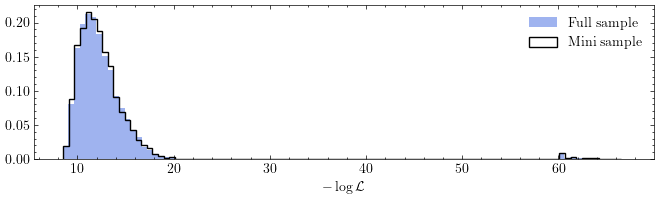

In [140]:
# Flat is the posterior for the flat model
# There are 208000 samples, data_file is the observed data file, model tells what scaling model to use
# env_gas and p_f_sync are ISM conditions
flat=constr_plot(208000, data_file, model='model2_flat', env_gas=env_gas, p_f_sync=p_f_sync, minisample_size=10000)

# This function will add derived parameters using the ones varied during the fit.
add_all_derived_params(flat)

# Print all params of the model
print(flat.params)

# Set prior limits on the parameters. See 
flat.set_prior_lims('log_m_chi', min_val=3, max_val=6.0)
flat.set_prior_lims('f_rel', min_val=0, max_val=1)
flat.set_prior_lims('f_26Al', min_val=0, max_val=0.5 if data_file=='spi_data' else 0.2)

# Function to remove points with log_m_chi greater than 5.7, can be useful to look at one peak of a bimodal dist.
# flat.filter(['log_m_chi'], lambda log_m_chi: 5.7-log_m_chi)

# Plot histogram of the log likelihood.
# Mini sample is basically a smaller subset of the sample chosen randomly. Speeds up the plot.
# Just check that minisample does not change the dist. of loglkl significantly
flat.hist_loglkl(color=col1)



Parameter: $\log(\tilde{f}_{\rm rel} m_{\chi}^2 / P_{\rm Th})$ [MeV$^2$]
Mean: 2.689e+00
Upper limit: 3.148e+00 (95%), 3.215e+00 (99%)
Lower limit: 1.440e+00 (95%), -3.085e-02 (99%)
1-sigma interval: 2.896e+00 (+1.741e-01 / -5.030e-01)
2-sigma interval: 2.896e+00 (+2.889e-01 / -2.423e+00)
Best-fit: 2.956e+00


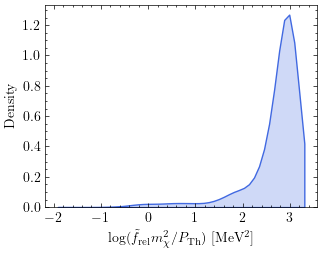

In [141]:
# This parameter is described in appendix of Report_Mar07 updated version.
# Useful for dark matter cross-section calculation
flat.histplot('log_f_msq_by_pth', kde=True, 
               color=col1, minisample=True)
flat.print_stats('log_f_msq_by_pth')



Parameter: $\dot{n}^{\rm inj, rel}_{\rm e^+} \rm{[s^{-1}]}$
Mean: 6.640e+42
Upper limit: 9.976e+42 (95%), 1.050e+43 (99%)
Lower limit: 2.215e+42 (95%), 7.766e+41 (99%)
1-sigma interval: 6.913e+42 (+2.270e+42 / -2.980e+42)
2-sigma interval: 6.913e+42 (+3.354e+42 / -5.547e+42)
Best-fit: 8.798e+42


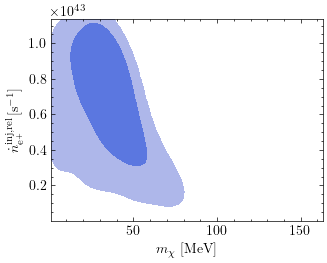

In [107]:
# Injection rate of positrons from the relativistic source (say, dark matter)
flat.print_stats('inj_rate_rel')
flat.covplot('m_chi', 'inj_rate_rel', kde=True, minisample=True, color=col1);

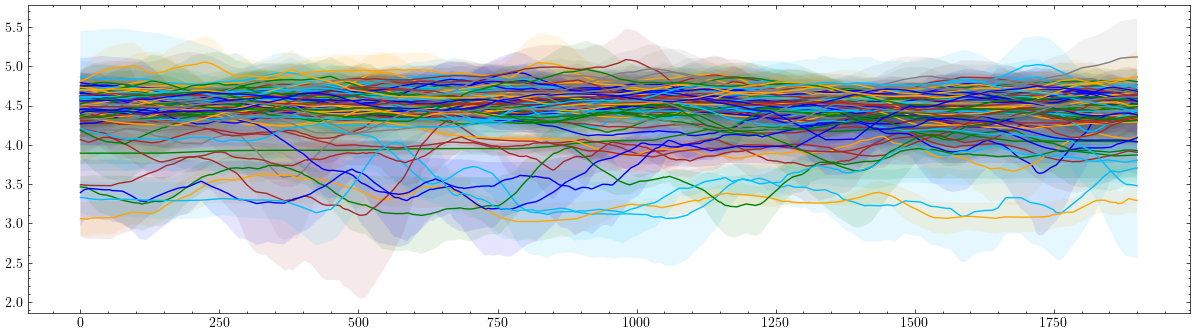

In [108]:
# Plot running stats to see if the MCMC chains have stabilised
flat.plot_running_stats('log_m_chi')

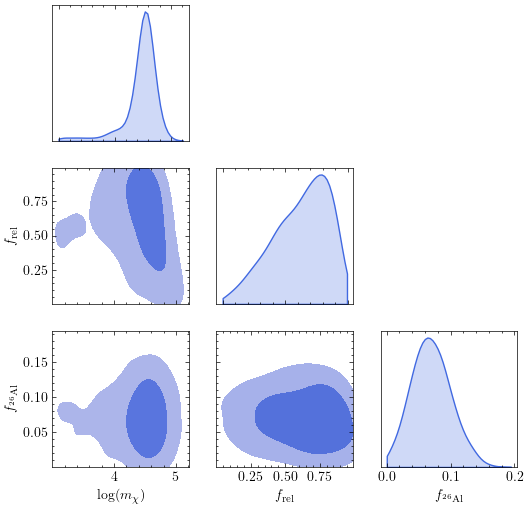

In [109]:
# Corner plot of given parameters
flat.cornerplot(['log_m_chi', 'f_rel', 'f_26Al'], kde_diag=True, kde_cov=True, 
               color=col1, minisample=True)
plt.savefig(f'posteriors/posterior_{env_gas}_m{p_f_sync}_{flat.model}_roi={flat.roi}.pdf')

In [110]:
# Functionality to produce tables
flat.table_alt2_singlecol(lims=['2sig', 'up95'], end_row=True, header_col=True)

['$\\log(m_{\\chi})$ & $4.530^{+0.315}_{-1.149}$\\\\ \\hline',
 '$f_{\\rm rel}$ & $<$ 0.912\\\\ \\hline',
 '$f_{\\beta}$ & $0.280^{+0.273}_{-0.204}$\\\\ \\hline',
 '$\\log\\mathcal{N}_{\\rm UPS}$ & $-5.655^{+1.097}_{-1.523}$\\\\ \\hline',
 '$\\theta_{\\rm UPS}$ & $-1.281^{+0.103}_{-0.077}$\\\\ \\hline',
 '$\\log\\mathcal{N}_{\\rm CMB}$ & $-12.970^{+5.022}_{-4.840}$\\\\ \\hline',
 '$\\log x_{\\rm FIR}$ & $0.642^{+3.005}_{-2.538}$\\\\ \\hline',
 '$\\log x_{\\rm NIR}$ & $0.343^{+3.052}_{-2.285}$\\\\ \\hline',
 '$p$ & $-2.513^{+0.356}_{-0.346}$\\\\ \\hline',
 '$f_{\\rm Ps}$ & $0.982^{+0.014}_{-0.024}$\\\\ \\hline',
 '$f_{\\rm ^{26}Al}$ & $0.068^{+0.033}_{-0.030}$\\\\ \\hline',
 '$m_{\\chi}$ [MeV] & $33.850^{+12.627}_{-13.488}$\\\\ \\hline',
 '$\\alpha_{\\rm UPS}$ & $-3.349^{+0.939}_{-1.270}$\\\\ \\hline',
 '$P_{\\rm Th}$ & $0.936^{+0.011}_{-0.007}$\\\\ \\hline',
 '$\\tilde{f}_{\\rm rel}$ & $0.640^{+0.201}_{-0.281}$\\\\ \\hline',
 '$\\tilde{f}_{\\rm rel} m_{\\chi}^2 / P_{\\rm Th}$ [MeV$^2$]

In [111]:
flat.print_stats_alt('f_rel')
flat.print_stats_alt('f_beta')
flat.print_stats_alt('f_26Al')

median=0.654, sig_1_p=0.195, sig_1_m=0.279, sig_2_p=0.279, sig_2_m=0.520
median=0.280, sig_1_p=0.273, sig_1_m=0.204, sig_2_p=0.516, sig_2_m=0.271
median=0.068, sig_1_p=0.033, sig_1_m=0.030, sig_2_p=0.066, sig_2_m=0.055


In [142]:
# Plot spectrum of the best-fit sample point in parameter space. 
# Requires models_clean.ipynb to run.

# flat.plot_spec(col=col1, save=False)

# plt.hlines(line_flux(flat.roi)/6, xmin=1e2, xmax=1e5)

## Model ```ptsrc```

['log_m_chi', 'f_rel', 'f_beta', 'log_norm_UPS', 'angle_UPS', 'log_norm_CMB', 'log_x_FIR', 'log_x_NIR', 'p', 'f_Ps', 'f_26Al', 'm_chi', 'alpha_UPS', 'p_th', 'f_tilde_rel', 'f_msq_by_pth', 'log_f_msq_by_pth', 'line_flux_rel', 'inj_rate_rel', 'log_inj_rate_rel', 'flux_IFA_pairs']


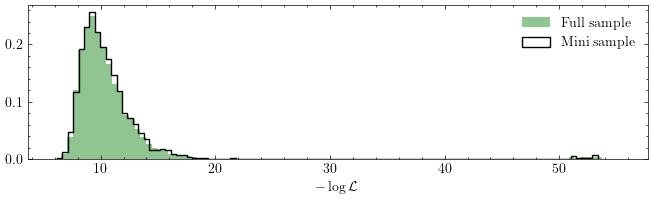

In [113]:
ptsrc=constr_plot(208000, data_file, model='model2_ptsrc', env_gas=env_gas, p_f_sync=p_f_sync, minisample_size=5000)

add_all_derived_params(ptsrc)
                           
print(ptsrc.params)

ptsrc.set_prior_lims('log_m_chi', min_val=3., max_val=6.)
ptsrc.set_prior_lims('f_rel', min_val=0, max_val=1)
ptsrc.set_prior_lims('f_26Al', min_val=0, max_val=0.5 if data_file=='spi_data' else 0.2)

ptsrc.hist_loglkl(color=col2)

In [114]:
ptsrc.print_stats_alt('f_rel')
ptsrc.print_stats_alt('f_beta')
ptsrc.print_stats_alt('f_26Al')

median=0.718, sig_1_p=0.166, sig_1_m=0.257, sig_2_p=0.229, sig_2_m=0.622
median=0.209, sig_1_p=0.260, sig_1_m=0.160, sig_2_p=0.637, sig_2_m=0.204
median=0.069, sig_1_p=0.028, sig_1_m=0.032, sig_2_p=0.061, sig_2_m=0.057


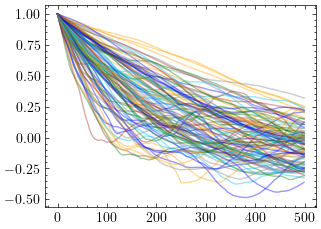

In [115]:
ptsrc.plot_autocorrelation('log_m_chi', max_lag=500)

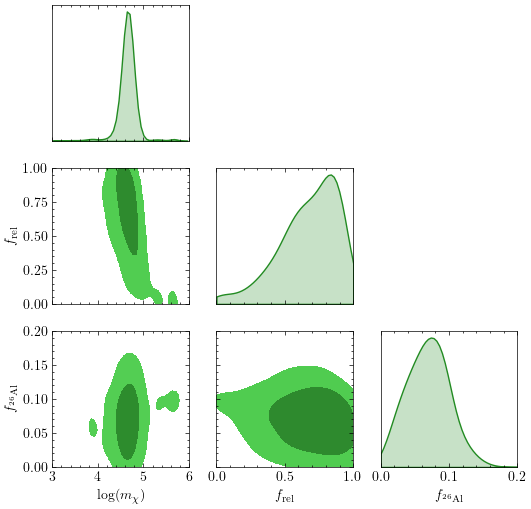

In [116]:
ptsrc.cornerplot(['log_m_chi', 'f_rel', 'f_26Al'], kde_diag=True, kde_cov=True, 
               color=col2, minisample=True)
plt.savefig(f'posteriors/posterior_{env_gas}_m{p_f_sync}_{ptsrc.model}_roi={ptsrc.roi}.pdf')

In [144]:
# ptsrc.plot_spec(col=col2, save=True)

median=4.487e-01, sig_1_p=1.111e-01, sig_1_m=1.658e-01, sig_2_p=1.533e-01, sig_2_m=3.927e-01


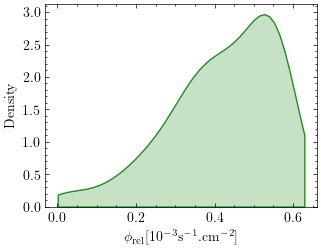

In [118]:
ptsrc.print_stats_alt_e('line_flux_rel')
ptsrc.histplot('line_flux_rel', kde=True, minisample=True, color=col2);

## Model ```like511```

['log_m_chi', 'f_rel', 'f_beta', 'log_norm_UPS', 'angle_UPS', 'log_norm_CMB', 'log_x_FIR', 'log_x_NIR', 'p', 'f_Ps', 'f_26Al', 'm_chi', 'alpha_UPS', 'p_th', 'f_tilde_rel', 'f_msq_by_pth', 'log_f_msq_by_pth', 'line_flux_rel', 'inj_rate_rel', 'log_inj_rate_rel', 'flux_IFA_pairs']


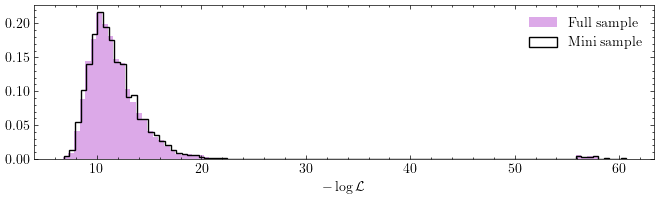

In [119]:
like511=constr_plot(208000, data_file, model='model2_like511', env_gas=env_gas, p_f_sync=p_f_sync, minisample_size=5000)

add_all_derived_params(like511)
                           
print(like511.params)

like511.set_prior_lims('log_m_chi', min_val=3., max_val=6.)
like511.set_prior_lims('f_rel', min_val=0, max_val=1)
like511.set_prior_lims('f_26Al', min_val=0, max_val=0.5 if data_file=='spi_data' else 0.2)

like511.hist_loglkl(color=col3)

In [120]:
like511.print_stats_alt('f_rel')
like511.print_stats_alt('f_beta')
like511.print_stats_alt('f_26Al')

median=0.680, sig_1_p=0.182, sig_1_m=0.295, sig_2_p=0.261, sig_2_m=0.611
median=0.254, sig_1_p=0.287, sig_1_m=0.182, sig_2_p=0.604, sig_2_m=0.245
median=0.066, sig_1_p=0.033, sig_1_m=0.028, sig_2_p=0.068, sig_2_m=0.055


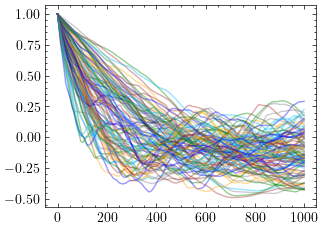

In [121]:
like511.plot_autocorrelation('log_m_chi', max_lag=1000)

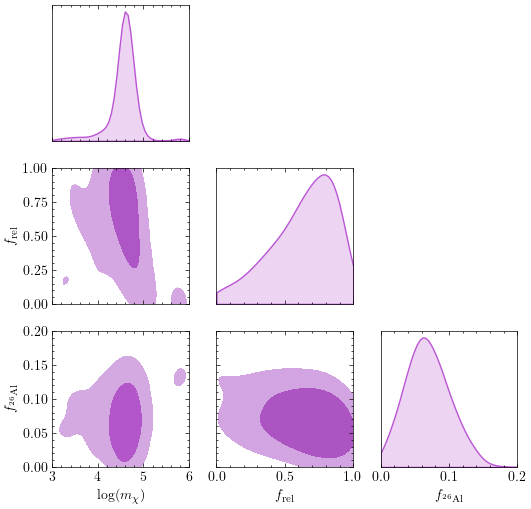

In [122]:
like511.cornerplot(['log_m_chi', 'f_rel', 'f_26Al'], kde_diag=True, kde_cov=True, 
               color=col3, minisample=True)
plt.savefig(f'posteriors/posterior_{env_gas}_m{p_f_sync}_{like511.model}_roi={like511.roi}.pdf')

In [143]:
# like511.plot_spec(col=col3, save=True)

median=4.251e-01, sig_1_p=1.204e-01, sig_1_m=1.904e-01, sig_2_p=1.733e-01, sig_2_m=3.839e-01


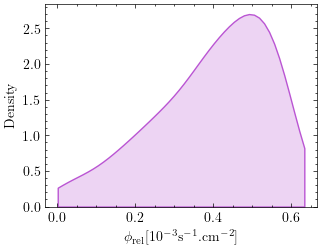

In [124]:
like511.print_stats_alt_e('line_flux_rel')
like511.histplot('line_flux_rel', kde=True, minisample=True, color=col3);

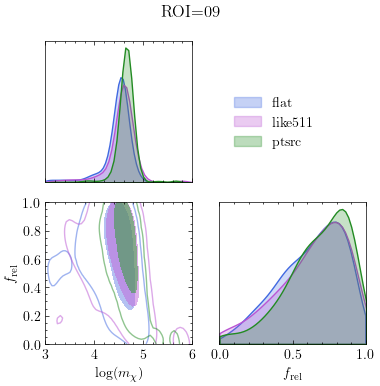

In [125]:
fig, axs=flat.init_cornerplot(n=2)
plot_params=dict(fig=fig, axs=axs, alpha=0.5, diag_style='filled', cov_style='contours_alt')
flat.cornerplot(['log_m_chi', 'f_rel'], kde_diag=True, kde_cov=True, color=col1, minisample=True, **plot_params)
like511.cornerplot(['log_m_chi', 'f_rel'], kde_diag=True, kde_cov=True, color=col3, minisample=True, **plot_params)
ptsrc.cornerplot(['log_m_chi', 'f_rel'], kde_diag=True, kde_cov=True, color=col2, minisample=True, **plot_params)

plt.fill([], [], color=col1, alpha=0.3, label=flat.model)
plt.fill([], [], color=col3, alpha=0.3, label=like511.model)
plt.fill([], [], color=col2, alpha=0.3, label=ptsrc.model)
fig.legend(loc=(0.6, 0.6))
plt.suptitle(f'ROI={flat.roi}')

plt.tight_layout()
plt.savefig(f'posteriors/compare_scalings_{env_gas}_m{p_f_sync}_{flat.roi}.pdf')

In [126]:
# Print bestfit values of samples
print(flat.dict_bestfit, like511.dict_bestfit, ptsrc.dict_bestfit, sep='\n')

{'log_m_chi': 4.521155114222249, 'f_rel': 0.7788633602670513, 'f_beta': 0.14966369679518693, 'log_norm_UPS': -6.188902330021357, 'angle_UPS': -1.3156503204404395, 'log_norm_CMB': -4.51865698697792, 'log_x_FIR': -1.131174608101932, 'log_x_NIR': -2.3943062049605177, 'p': -2.855958017126305, 'f_Ps': 0.9924875795631065, 'f_26Al': 0.0714729429377618, 'm_chi': 33.20130193754349, 'alpha_UPS': -3.8339044438351513, 'p_th': 0.9364239101007773, 'f_tilde_rel': 0.7673428562354012, 'f_msq_by_pth': 903.2899713365714, 'log_f_msq_by_pth': 2.9558271885592617, 'line_flux_rel': 0.48979494513505656, 'inj_rate_rel': 8.798144869814815e+42, 'log_inj_rate_rel': 42.94439110877101, 'flux_IFA_pairs': 0.13008177888133293, 'loglkl': 8.460337820190706, 'AIC': 36.92067564038141}
{'log_m_chi': 4.4321184016061945, 'f_rel': 0.7513215568101077, 'f_beta': 0.1813204305170616, 'log_norm_UPS': -6.291177793046712, 'angle_UPS': -1.3201771748661064, 'log_norm_CMB': -4.144952050795338, 'log_x_FIR': -0.28596267171022405, 'log_x_N

In [127]:

flat.print_stats('m_chi')
like511.print_stats('m_chi')
ptsrc.print_stats('m_chi')



Parameter: $m_{\chi}$ [MeV]
Mean: 3.412e+01
Upper limit: 6.025e+01 (95%), 8.191e+01 (99%)
Lower limit: 7.045e+00 (95%), 1.489e+00 (99%)
1-sigma interval: 3.385e+01 (+1.263e+01 / -1.349e+01)
2-sigma interval: 3.385e+01 (+3.604e+01 / -3.144e+01)
Best-fit: 3.320e+01


Parameter: $m_{\chi}$ [MeV]
Mean: 4.551e+01
Upper limit: 7.093e+01 (95%), 1.970e+02 (99%)
Lower limit: 8.809e+00 (95%), 1.758e+00 (99%)
1-sigma interval: 3.963e+01 (+1.461e+01 / -1.360e+01)
2-sigma interval: 3.963e+01 (+5.177e+01 / -3.634e+01)
Best-fit: 2.705e+01


Parameter: $m_{\chi}$ [MeV]
Mean: 5.081e+01
Upper limit: 7.231e+01 (95%), 2.779e+02 (99%)
Lower limit: 2.347e+01 (95%), 5.709e+00 (99%)
1-sigma interval: 4.511e+01 (+1.289e+01 / -1.094e+01)
2-sigma interval: 4.511e+01 (+5.370e+01 / -3.298e+01)
Best-fit: 2.680e+01


In [128]:
# Print AIC values
flat.AIC, like511.AIC, ptsrc.AIC

(36.92067564038141, 33.3990822045336, 32.167745558230365)

In [130]:
# Produce the table of constraints

lims=['up95', 'lo95', '', '', '', 'up95', '', '', '', '', '', 'up95', '', '', '', '', '', 'up95', 'up95']
flat_col=flat.table_alt2_singlecol(lims=lims, header_col=True)
like511_col=like511.table_alt2_singlecol(lims=lims)
ptsrc_col=ptsrc.table_alt2_singlecol(lims=lims, end_row=True)
table=[flat_col[i]+like511_col[i]+ptsrc_col[i] for i,s in enumerate(flat_col)]

with open(f'posterior_tables/table_{env_gas}_m{flat.p_f_sync}_{flat.roi}.txt', 'w', encoding='utf-8') as f:
    for row in table:
        print(row, file=f)
        print(row)

$\log(m_{\chi})$ & $<$ 4.780 & $<$ 4.851 & $<$ 4.859\\ \hline
$f_{\rm rel}$ & $>$ 0.214 & $>$ 0.174 & $>$ 0.246\\ \hline
$f_{\beta}$ & $0.280^{+0.273}_{-0.204}$ & $0.254^{+0.287}_{-0.182}$ & $0.209^{+0.260}_{-0.160}$\\ \hline
$\log\mathcal{N}_{\rm UPS}$ & $-5.655^{+1.097}_{-1.523}$ & $-5.260^{+0.921}_{-1.266}$ & $-5.675^{+0.935}_{-1.739}$\\ \hline
$\theta_{\rm UPS}$ & $-1.281^{+0.103}_{-0.077}$ & $-1.251^{+0.103}_{-0.079}$ & $-1.282^{+0.084}_{-0.083}$\\ \hline
$\log\mathcal{N}_{\rm CMB}$ & $<$ -5.461 & $<$ -5.941 & $<$ -5.475\\ \hline
$\log x_{\rm FIR}$ & $0.642^{+3.005}_{-2.538}$ & $1.116^{+2.527}_{-2.721}$ & $0.829^{+2.821}_{-2.639}$\\ \hline
$\log x_{\rm NIR}$ & $0.343^{+3.052}_{-2.285}$ & $0.603^{+2.676}_{-2.531}$ & $0.655^{+2.897}_{-2.615}$\\ \hline
$p$ & $-2.513^{+0.356}_{-0.346}$ & $-2.553^{+0.359}_{-0.318}$ & $-2.491^{+0.340}_{-0.364}$\\ \hline
$f_{\rm Ps}$ & $0.982^{+0.014}_{-0.024}$ & $0.981^{+0.015}_{-0.032}$ & $0.980^{+0.015}_{-0.029}$\\ \hline
$f_{\rm ^{26}Al}$ & $0.068^{+

In [131]:
print(flat.params_tex)

['$\\log(m_{\\chi})$', '$f_{\\rm rel}$', '$f_{\\beta}$', '$\\log\\mathcal{N}_{\\rm UPS}$', '$\\theta_{\\rm UPS}$', '$\\log\\mathcal{N}_{\\rm CMB}$', '$\\log x_{\\rm FIR}$', '$\\log x_{\\rm NIR}$', '$p$', '$f_{\\rm Ps}$', '$f_{\\rm ^{26}Al}$', '$m_{\\chi}$ [MeV]', '$\\alpha_{\\rm UPS}$', '$P_{\\rm Th}$', '$\\tilde{f}_{\\rm rel}$', '$\\tilde{f}_{\\rm rel} m_{\\chi}^2 / P_{\\rm Th}$ [MeV$^2$]', '$\\log(\\tilde{f}_{\\rm rel} m_{\\chi}^2 / P_{\\rm Th})$ [MeV$^2$]', '$\\phi_{\\rm rel} \\rm{[10^{-3}s^{-1}.cm^{-2}]}$', '$\\dot{n}^{\\rm inj, rel}_{\\rm e^+} \\rm{[s^{-1}]}$', '$\\log{\\dot{n}^{\\rm inj, rel}_{\\rm e^+} \\rm{[s^{-1}]}}$', '$\\phi^{\\rm IFA}_{e^\\pm} \\rm{[10^{-3} e^{\\pm} s^{-1}.cm^{-2}]}$']


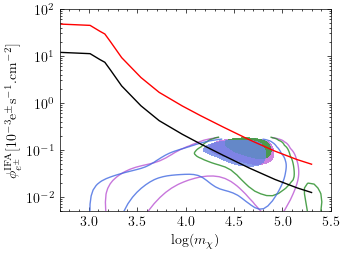

In [132]:
# Produce the IFA flux plot

ax=plt.axes()
style='contours_alt'
like511.covplot('log_m_chi', 'flux_IFA_pairs', kde=True, minisample=True, color=col3, ax=ax, style=style, alpha=0.8)
ptsrc.covplot('log_m_chi', 'flux_IFA_pairs', kde=True, minisample=True, color=col2, ax=ax, style=style, alpha=0.8)
flat.covplot('log_m_chi', 'flux_IFA_pairs', kde=True, minisample=True, color=col1, ax=ax, style=style, alpha=0.8)

# ax.set_xlim(-5, 3)
ax.set_ylim(None, 0.5)

ax.set_xlim(2.7, 5.5)
ax.set_ylim(0.005, 100)

ax.set_yscale('log')

#lims_thermal_no_boost
mx_noboost = np.array([0.5198010345550731, 0.7017038801582891, 1.0339028871375857, 1.3056812156021698, 1.467289950220061, 1.676619211397663, 2.189130210039652, 3.462314831829514, 5.34074435172903, 9.257970879808596, 14.28075635870464, 24.549654032761342, 45.30109682758057, 83.59341321238979, 141.32739393078566, 199.73417033432835])
flux_IFA_pairs_noboost = np.array([0.011814816042134019, 0.01150776891098719, 0.01111074876082485, 0.008316664405898472, 0.007290713260588952, 0.004998693249736132, 0.002288723966951868, 0.0008639082864860015, 0.0004169425653903466, 0.00021397771852635624, 0.00013320593635781174, 0.00007595546922410478, 0.000041088776322195754, 0.000023429265772460757, 0.000015509486883903142, 0.000012344873802617118])

ax.plot(np.log10(mx_noboost)+3, flux_IFA_pairs_noboost*1e3, 'k')
ax.plot(np.log10(mx_noboost)+3, flux_IFA_pairs_noboost*4e3, 'r')

plt.savefig(f'posteriors/thermal_comparison_{flat.env_gas}_m{flat.p_f_sync}_{flat.roi}.png', dpi=300)


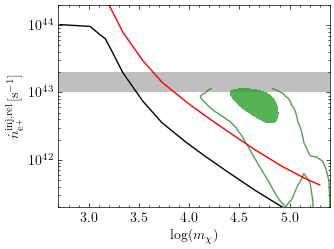

In [137]:
# Produce the plot of relativistic positron injection rate vs mx

ax=plt.axes()
style='contours_alt'
# like511.covplot('log_m_chi', 'inj_rate_rel', kde=True, minisample=True, color=col3, ax=ax, style=style, alpha=0.8)
ptsrc.covplot('log_m_chi', 'inj_rate_rel', kde=True, minisample=True, color=col2, ax=ax, style=style, alpha=0.8)
# flat.covplot('log_m_chi', 'inj_rate_rel', kde=True, minisample=True, color=col1, ax=ax, style=style, alpha=0.8)

# ax.set_xlim(-5, 3)
# ax.set_ylim(None, 0.5)

ax.set_xlim(2.7, 5.4)
ax.set_ylim(2e41,2e44)

ax.set_yscale('log')

#lims_thermal_no_boost
mx_noboost = np.array([0.5198010345550731, 0.7017038801582891, 1.0339028871375857, 1.3056812156021698, 1.467289950220061, 1.676619211397663, 2.189130210039652, 3.462314831829514, 5.34074435172903, 9.257970879808596, 14.28075635870464, 24.549654032761342, 45.30109682758057, 83.59341321238979, 141.32739393078566, 199.73417033432835])
flux_IFA_pairs_noboost = np.array([0.011814816042134019, 0.01150776891098719, 0.01111074876082485, 0.008316664405898472, 0.007290713260588952, 0.004998693249736132, 0.002288723966951868, 0.0008639082864860015, 0.0004169425653903466, 0.00021397771852635624, 0.00013320593635781174, 0.00007595546922410478, 0.000041088776322195754, 0.000023429265772460757, 0.000015509486883903142, 0.000012344873802617118])

ax.plot(np.log10(mx_noboost)+3, flux_IFA_pairs_noboost*8.6e45, 'k')
ax.plot(np.log10(mx_noboost)+3, flux_IFA_pairs_noboost*4*8.6e45, 'r')

ax.fill_between(y1=1e43, y2=2e43, x=np.linspace(2.7, 5.4), alpha=0.5, color='gray', zorder=-2, linewidth=0)

# plt.savefig(f'posteriors/thermal_comparison_rate_{flat.env_gas}_m{flat.p_f_sync}_{flat.roi}.pdf', dpi=300)